# Exploration distribution goodness of fit parameters

First of, new order parameters have been introduced that summerase the hypothesis well in one go. With only a few numbers. 

We are then going to look at the distribution of these infunction of different settings. 

In [1]:
# Necessary imports:

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import time
from helpFunctions import * # plotting
from generateGLV import * # Generating
from fitGLV import * # Fitting

First test is the one for the following setting:

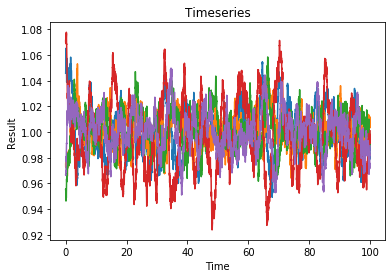

In [184]:
noiseSetting = {
    "noiseType" : "LangevinLinear",
    "noiseStrength" : 0.02
}

pertuSetting = {
    "period" : 1000,
    "strenght" : 0.05
}

genSetting = {
    "interactionStrenght" : 1
}

numberSpecies = 5
numberExperiments = 3

# Generate

TS = TS_GLV(numberSpecies,numberExperiments,noiseSetting,genSetting,pertuSetting)
TS.generate()
TS.plot(0)

And we secretly also imply that:
* tMax = 100
* timestep = 0.01
* intergrationType = Euler

-----
First we evaluate if the numbers of the summerasing values that come out are correct

In [181]:
fitObj = fitGLV(TS)
fitObj.computeNullHypo()

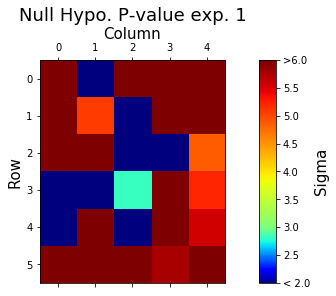

In [173]:
fitObj.plotNullHypo(1)

After many debugging and shifting. The numbers are correct.
The summerasing values are categorised in the categories:
* G = Growth rate
* S = Selfin interaction
* I = Interaction

and then an weighted average is taken of the summary is taken. The following summaries are computed:

* percent = percentage of parameters above some significant threshold sigma value within its group. 
* median = median sigma within its group
* avg = average sigma withing its group
This all is then computed again with but then the p-value is multiplied by a modifier. This modifier then takes into account that the real value maybe already be very close to zero and hence we want to reflect then that when already close to zero it is good. -> so we enhance the significance. 

So the modified should not be interpreted to hard. But just compare it to the non modified inorder to see if it is simply non-significance maybe comes from the fact that the real value is already close. -> Doing this modification, if we now see a non-significant parameter. This cannot then cannot be duo that it already lies close to the zero value. 

This modification only makes sense when looking at the nullNypothesis. (should be modified for general!). 

------
Thus we have the following choices that we make:
* the sigma threshold for percent. Now it is 3 sigma
* the weights when computing the weighted sum. Now it is [15,10,75] for [G,S,I]
* And the choice of modifier. at the moment it is the $\eta$= abs(realMat)/abs(selfInt), and then p_new = p_old * $\sqrt{\eta}$

------

One nice observation that is seen with these seeds and settings. Is that when the values are all roughly equal to self interaction, the modified values did not really significantly change. However this does happen in the first experiment where the change is roughly 0.3-0.4 sigma, while with the other only 0.03 sigma. 

When you have a look at the modifier you can also see that indeed in the first experment there are much more low value.

-----------
## Distributions
Now it is some time to look at distributions. First Let's use the same settings as above and now generate a whole lot of experiments

/home/lennart/Dropbox/VUB/2Ma Physics and Astronomy/MasterThesis/GitCode/PostFWO/generateGLV.py:251: RuntimeWarning: overflow encountered in multiply
  return currentState*(self.growth[self.e] + np.dot(currentState,self.interactionMatrix[self.e]))


556.2 seconds


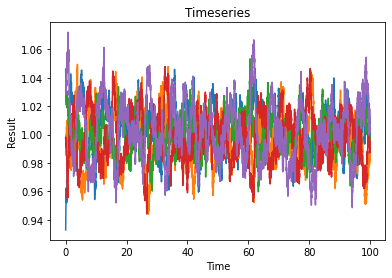

In [2]:
noiseSetting = {
    "noiseType" : "LangevinLinear",
    "noiseStrength" : 0.02
}

pertuSetting = {
    "period" : 1000,
    "strenght" : 0.05
}

genSetting = {
    "interactionStrenght" : 1
}

numberSpecies = 5
numberExperiments = 1000 # Time, roughly 0.4 seconds/ experiment (single thread)

# Generate

TS = TS_GLV(numberSpecies,numberExperiments,noiseSetting,genSetting,pertuSetting)
t0 = time.time()
TS.generate()
t1 = time.time()
total = t1-t0
print(f"{np.round(total,2)} seconds" )
TS.plot(0)

In [195]:
np.save("DataStorage/resultN002I1.npy",TS.result)
np.save("DataStorage/betaN002I1.npy",TS.beta)
np.save("DataStorage/modelDiffN002I1.npy",TS.modelDiff)
np.save("DataStorage/noiseDiffN002I1.npy",TS.noiseDiff)

In [3]:
fitN002I1 = fitGLV(TS)

In [4]:
fitN002I1.computeNullHypo()

In [5]:
e, n1, n = fitN002I1.trueMat.shape

Now lets make histograms and such

In [264]:
def plotPercent(summary, e, n, modified = False):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    ((ax1, ax2), (ax3, ax4)) = axs
    
    # Title and lables
    fig.suptitle("Percentage significant >3 sigma", fontsize = 18)
    ax1.set_title("percent Growth",fontsize = 15)
    ax2.set_title("percent Self-Int",fontsize = 15)
    ax3.set_title("percent Interaction",fontsize = 15)
    ax4.set_title("percentWAvg",fontsize = 15)
    for ax in axs.flat:
        ax.set(xlabel='% significant', ylabel='count')
    
    # Bins
    numI = n*(n-1) # Number of interaction elements
    numBins = int(np.sqrt(e) if np.sqrt(e) < 100 else 100)
    binEdgesGandS = np.arange(n+2)/n if numBins > (n+1) else numBins
    binEdgesI = np.arange(numI+2)/numI if numBins > (numI+1) else numBins
    
    # plotting
    ax1.hist(summary["percentG"],binEdgesGandS)# Use align left i you want to center the data
    ax2.hist(summary["percentS"],binEdgesGandS)# But should be care full because else the histogram
    ax3.hist(summary["percentI"],binEdgesI)# Is not interperet correct.
    ax4.hist(summary["percentWAvg"],numBins)

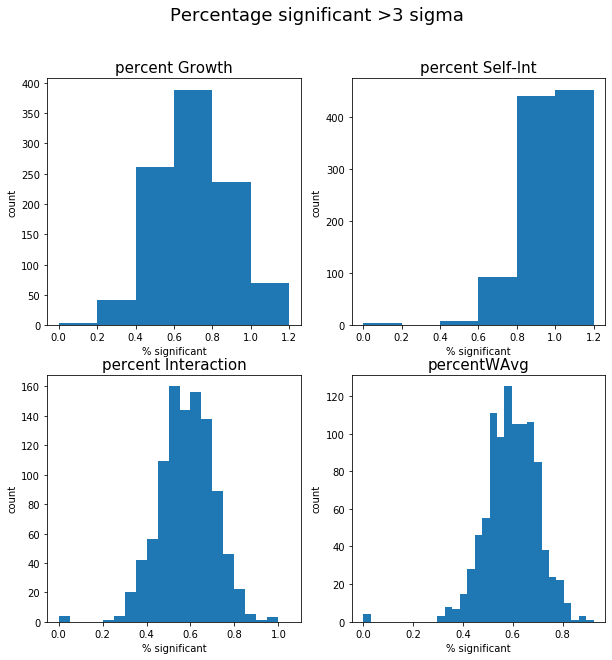

In [281]:
plotPercent(fitN002I1.nullSummary, e, n)

In [272]:
def plotMedian(summary, e, n, modified = False):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    ((ax1, ax2), (ax3, ax4)) = axs
    
    # Title and lables
    fig.suptitle("Median sigma", fontsize = 18)
    ax1.set_title("Median sigma Growth",fontsize = 15)
    ax2.set_title("Median sigma Self-Int",fontsize = 15)
    ax3.set_title("Median sigma Interaction",fontsize = 15)
    ax4.set_title("MedianWAvg",fontsize = 15)
    for ax in axs.flat:
        ax.set(xlabel='% Mean sigma', ylabel='count')
    
    # Bins
    numI = n*(n-1) # Number of interaction elements
    numBins = int(np.sqrt(e) if np.sqrt(e) < 100 else 100)
    #binEdgesGandS = np.arange(n+2)/n if numBins > (n+1) else numBins
    #binEdgesI = np.arange(numI+2)/numI if numBins > (numI+1) else numBins
    
    # plotting
    ax1.hist(summary["medianG"],numBins)# Use align left i you want to center the data
    ax2.hist(summary["medianS"],numBins)# But should be care full because else the histogram
    ax3.hist(summary["medianI"],numBins)# Is not interperet correct.
    ax4.hist(summary["medianWAvg"],numBins)

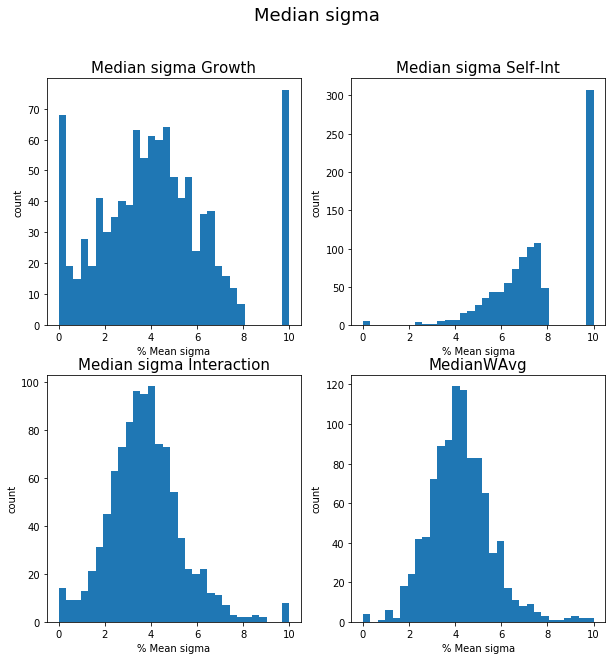

In [274]:
plotMedian(fitN002I1.nullSummary, e, n)

In [18]:
def plotThesisFigure(summary, e, n):
    fig, axs = plt.subplots(2, 3, figsize=(15,10),constrained_layout=True)
    ((ax1, ax2, ax3), (ax4, ax5, ax6)) = axs
    #fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    # Title and lables
    fig.suptitle("Distribution summary variables over 1000 simulations", fontsize = 18)
    ax1.set_title(r"Percent significant interaction",fontsize = 15)
    ax2.set_title(r"Percent significant  growth rate",fontsize = 15)
    ax3.set_title(r"Percent significant  self interaction",fontsize = 15)
    
    ax4.set_title(r"Median $\sigma$ interaction",fontsize = 15)
    ax5.set_title(r"Median $\sigma$ growth rate",fontsize = 15)
    ax6.set_title(r"Median $\sigma$ self interaction",fontsize = 15)
    
    for ax in axs[0]:
        ax.set_xlabel(r"% significant",fontsize=15)
    for ax in axs[1]:
        ax.set_xlabel(r"median $\sigma$",fontsize=15)
    ax1.set_ylabel("Count",fontsize=15)
    ax4.set_ylabel("Count",fontsize=15)
    
    # Bins
    numI = n*(n-1) # Number of interaction elements
    numBins = int(np.sqrt(e) if np.sqrt(e) < 100 else 100)
    binEdgesGandS = np.arange(n+2)/n if numBins > (n+1) else numBins
    binEdgesI = np.arange(numI+2)/numI if numBins > (numI+1) else numBins
    numBins = int(np.sqrt(e) if np.sqrt(e) < 100 else 100)
    
    # plotting
    ax1.hist(summary["medianG"],numBins)# Use align left i you want to center the data
    ax2.hist(summary["medianS"],numBins)# But should be care full because else the histogram
    ax3.hist(summary["medianI"],numBins)# Is not interperet correct.
    
    # plotting
    ax4.hist(summary["percentG"],binEdgesGandS)# Use align left i you want to center the data
    ax5.hist(summary["percentS"],binEdgesGandS)# But should be care full because else the histogram
    ax6.hist(summary["percentI"],binEdgesI)# Is not interperet correct.

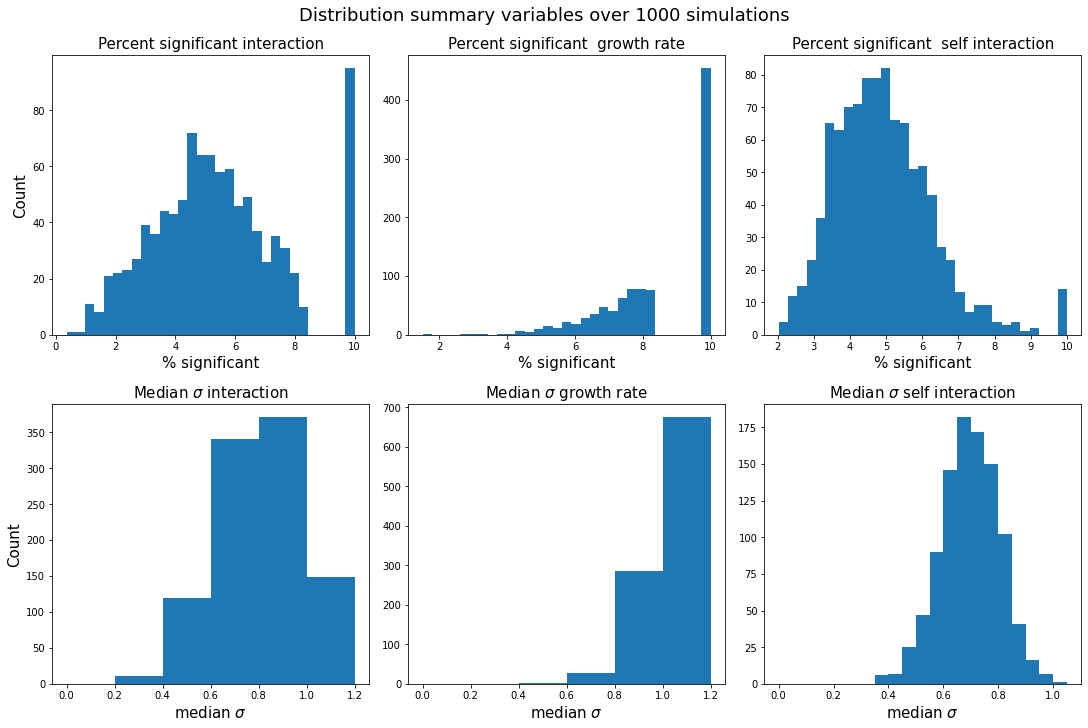

In [20]:
plotThesisFigure(fitN002I1.nullSummary, e, n)
plt.savefig("ThesisFigures/SimulationData/Distribution.png")

------
Plot for figure in thesis:

In [ ]:
def plotAvg(summary, e, n, modified = False):
    fig, axs = plt.subplots(2, 2, figsize=(10,10))
    ((ax1, ax2), (ax3, ax4)) = axs
    
    # Title and lables
    fig.suptitle("Average sigma", fontsize = 18)
    ax1.set_title("Average sigma Growth",fontsize = 15)
    ax2.set_title("Average sigma Self-Int",fontsize = 15)
    ax3.set_title("Average sigma Interaction",fontsize = 15)
    ax4.set_title("MedianWAvg",fontsize = 15)
    for ax in axs.flat:
        ax.set(xlabel='% Mean sigma', ylabel='count')
    
    # Bins
    numI = n*(n-1) # Number of interaction elements
    numBins = int(np.sqrt(e) if np.sqrt(e) < 100 else 100)
    #binEdgesGandS = np.arange(n+2)/n if numBins > (n+1) else numBins
    #binEdgesI = np.arange(numI+2)/numI if numBins > (numI+1) else numBins
    
    # plotting
    ax1.hist(summary["avgG"],numBins)# Use align left i you want to center the data
    ax2.hist(summary["avgS"],numBins)# But should be care full because else the histogram
    ax3.hist(summary["avgI"],numBins)# Is not interperet correct.
    ax4.hist(summary["avgWAvg"],numBins)

------------------
Great now we understand the values. Let's now evaluate different distributions.

378.92 seconds


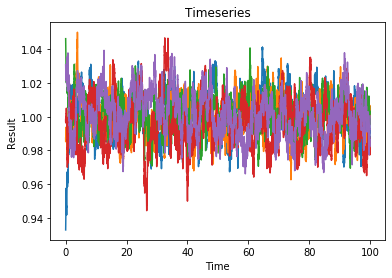

In [282]:
noiseSetting = {
    "noiseType" : "LangevinLinear",
    "noiseStrength" : 0.02
}

pertuSetting = {
    "period" : 1000,
    "strenght" : 0.05
}

genSetting = {
    "interactionStrenght" : 0.02
}

numberSpecies = 5
numberExperiments = 1000 # Time, roughly 0.4 seconds/ experiment (single thread)

# Generate

TS = TS_GLV(numberSpecies,numberExperiments,noiseSetting,genSetting,pertuSetting)
t0 = time.time()
TS.generate()
t1 = time.time()
total = t1-t0
print(f"{np.round(total,2)} seconds" )
TS.plot(0)

In [284]:
fitN002I002 = fitGLV(TS)
fitN002I002.computeNullHypo()
e, n1, n = fitN002I002.trueMat.shape

In [286]:
fitN002I002.nullSummary["indexInvalidExp"]

array([], dtype=float64)

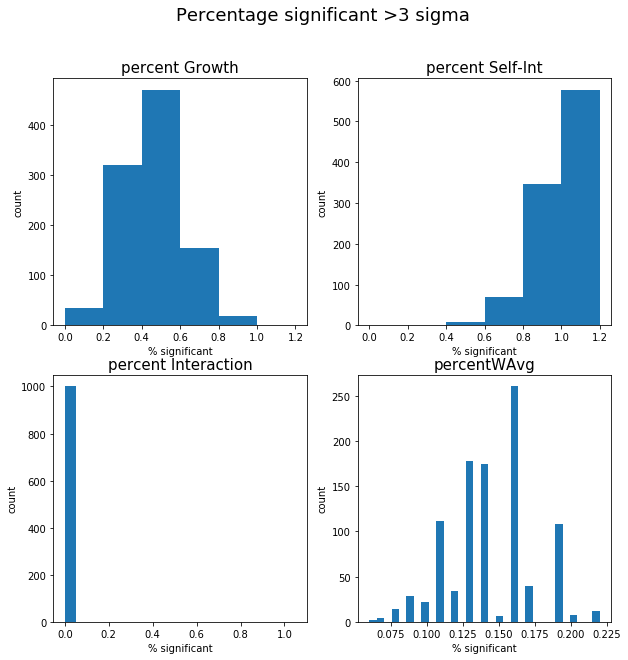

In [285]:
plotPercent(fitN002I002.nullSummary, e, n)

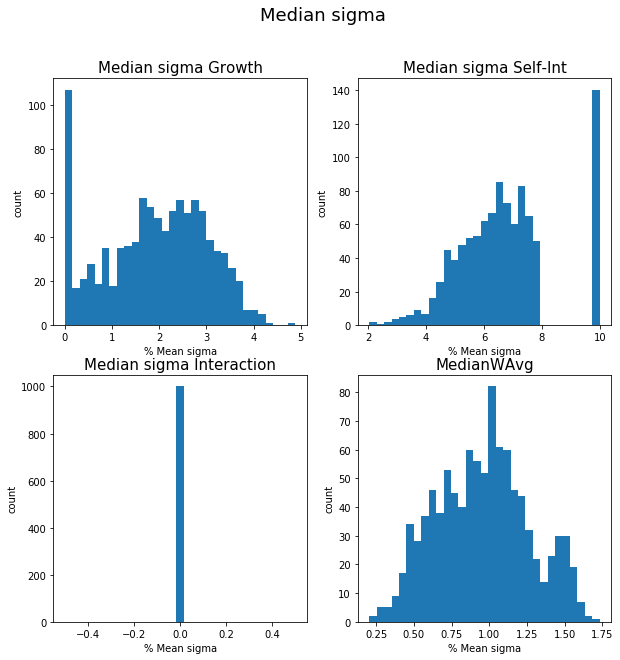

In [287]:
plotMedian(fitN002I002.nullSummary, e, n)

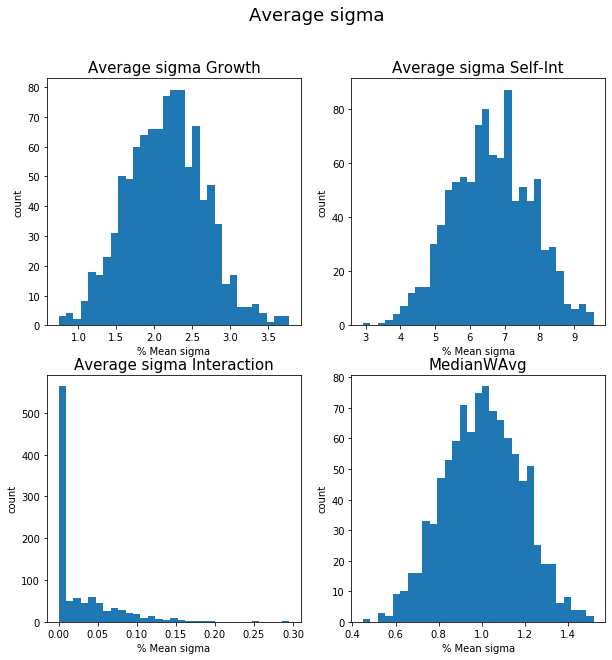

In [289]:
plotAvg(fitN002I002.nullSummary, e, n)

-----------

Now let's do some hypothesis with the "Real matrix"

In [ ]:
fitN002I002.trueMat.shape

In [ ]:
fitObjigma,summary) = fitN002I002.hypo(fitN002I002.trueMat,plot = False)